In [2]:
import numpy as np
import pandas as pd

from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import model_selection, preprocessing
import xgboost as xgb
color = sns.color_palette()
sns.set()

%matplotlib inline

import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

from funcs import correct_macro_df, correct_flats_info_df, get_corr_empty_info#, prepare_choosed_features

pd.options.mode.chained_assignment = None # default='warn'
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

In [3]:
train_df = pd.read_csv("data/train.csv", parse_dates=['timestamp'])
test_df = pd.read_csv("data/test.csv", parse_dates=['timestamp'])

train_df = correct_flats_info_df(train_df)
test_df = correct_flats_info_df(test_df)

macro_df = pd.read_csv("data/macro.csv", parse_dates=['timestamp'])
macro_df = correct_macro_df(macro_df=macro_df)
macro_df.columns = ["timestamp"] + ["macro_" + c for c in macro_df.columns if c!="timestamp"]

train_with_macro_df = pd.merge(train_df, macro_df, how='left', on='timestamp')
test_with_macro_df = pd.merge(test_df, macro_df, how='left', on='timestamp')

In [4]:
def add_dates_info(df):
    def correct_str_month(date):
        str_month = str(date.month)
        if len(str_month)==1:
            return "0" + str_month
        else:
            return str_month
    
    df = df.copy()
    df["timestamp_dt"] = pd.to_datetime(df["timestamp"])
    df["timestamp_year"] = df["timestamp_dt"].apply(lambda x: int(x.year))
    df["timestamp_year_month"] = df["timestamp_year"].astype(str) + df["timestamp_dt"].apply(correct_str_month)
    return df

train_with_macro_df = add_dates_info(train_with_macro_df)
test_with_macro_df = add_dates_info(test_with_macro_df)

In [5]:
def add_price_per_sq_meter(df):
    df = df.copy()
    df["price_per_sq_meter"] = df["price_doc"] / df["full_sq"]
    return df

train_with_macro_df = add_price_per_sq_meter(train_with_macro_df)

In [6]:
macro_with_avg_price_df = train_with_macro_df[
    ['timestamp_year_month', 'price_doc', 'price_per_sq_meter'] + list(
        filter(lambda x: "macro_" in x, train_with_macro_df.columns))]

mcols = ['timestamp_year_month', 
         'price_per_sq_meter',
         'macro_oil_urals',
         'macro_gdp_quart',
         'macro_gdp_quart_growth',
         'macro_rts',
         'macro_micex',
         'macro_micex_rgbi_tr',
         'macro_micex_cbi_tr',
         'macro_deposits_value',
         'macro_deposits_growth',
         'macro_deposits_rate',
         'macro_mortgage_value',
         'macro_mortgage_growth',
         'macro_mortgage_rate',
         'macro_unemployment']

macro_with_avg_price_gb = macro_with_avg_price_df[mcols].groupby(['timestamp_year_month'])
macro_with_avg_price_df_grouped = macro_with_avg_price_gb.mean()

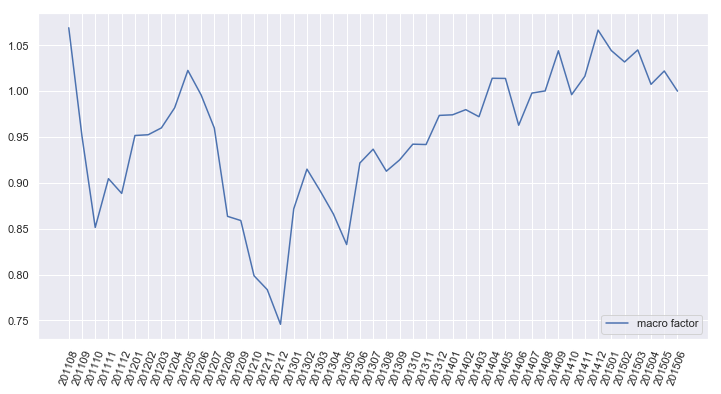

In [12]:
last_avg_price = macro_with_avg_price_df_grouped.price_per_sq_meter.loc["201506"]
macro_factor_multiplier = macro_with_avg_price_df_grouped.price_per_sq_meter / last_avg_price

plt.figure(figsize=(12,6))

plt.plot(macro_factor_multiplier.index, macro_factor_multiplier, label="macro factor")

plt.legend(loc='lower right')
plt.xticks(rotation=70)

plt.show()

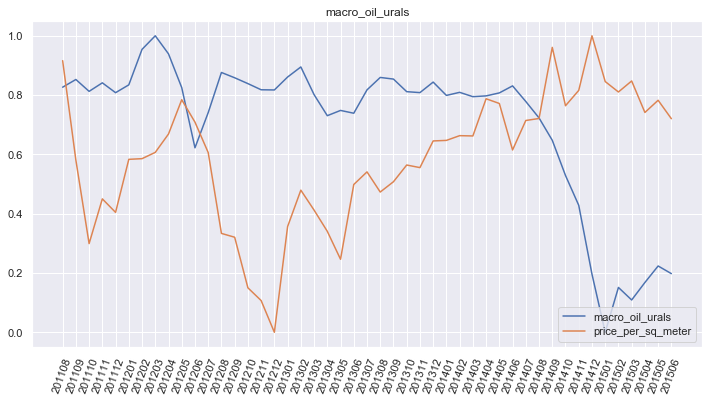

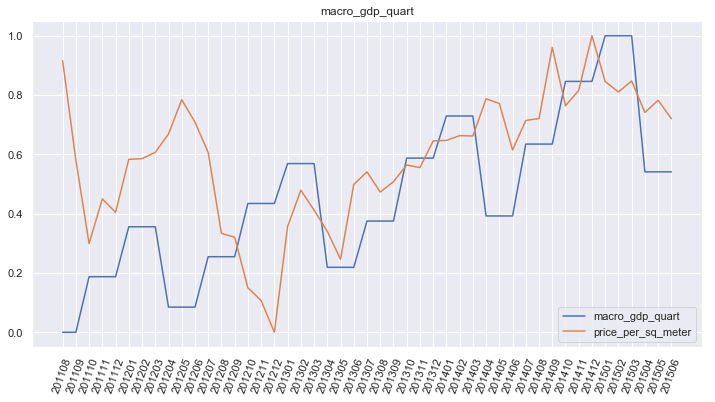

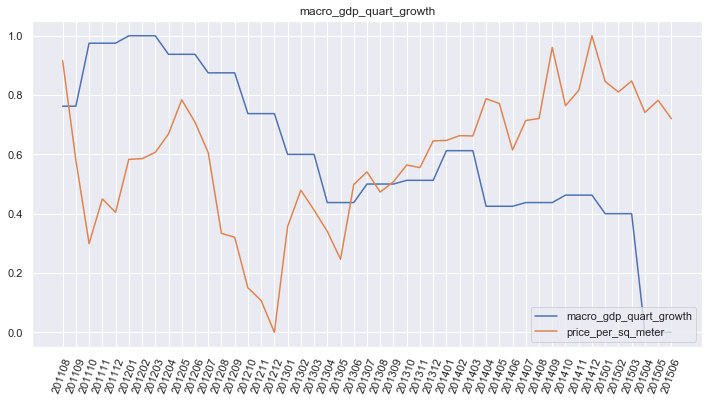

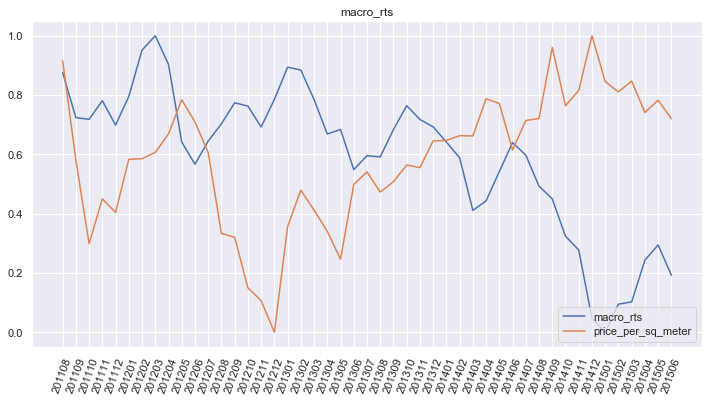

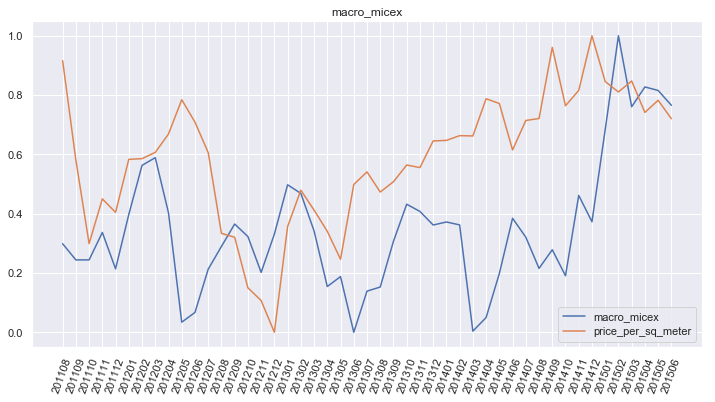

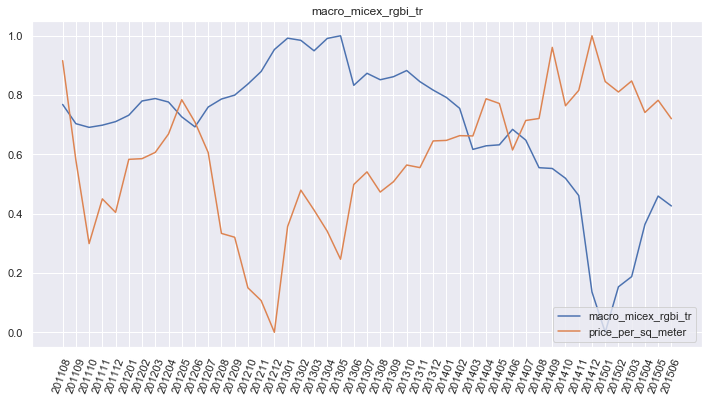

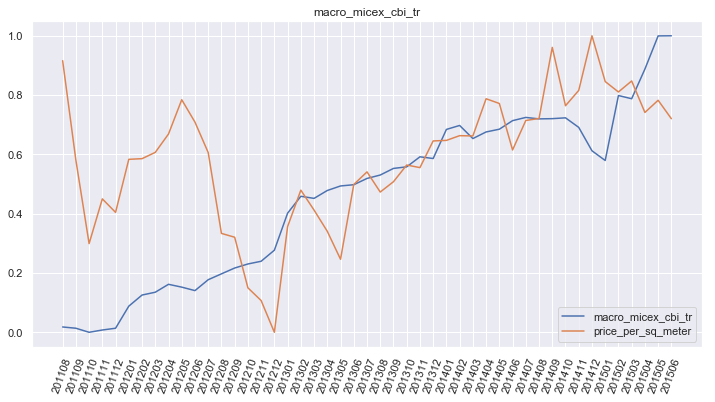

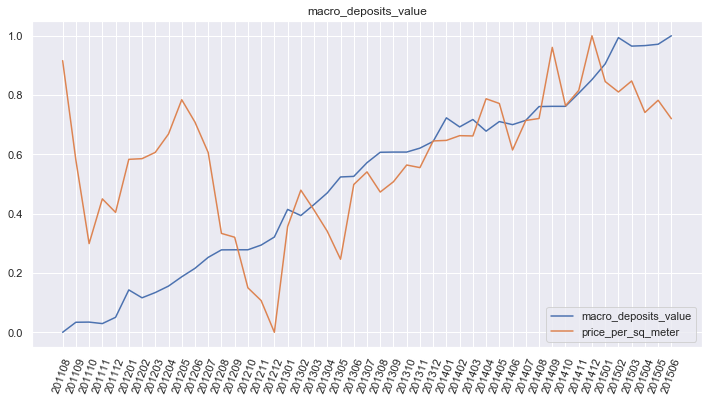

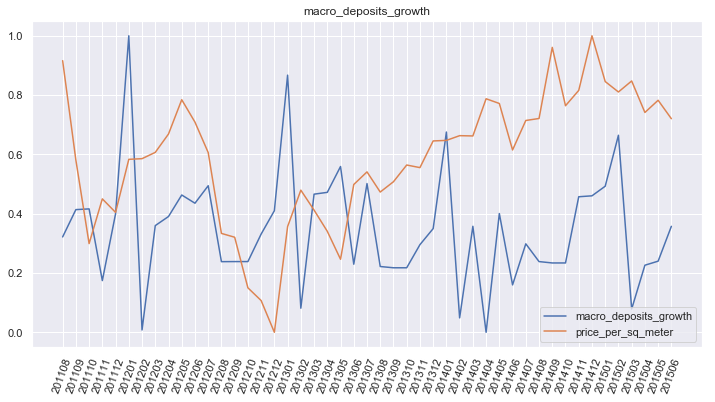

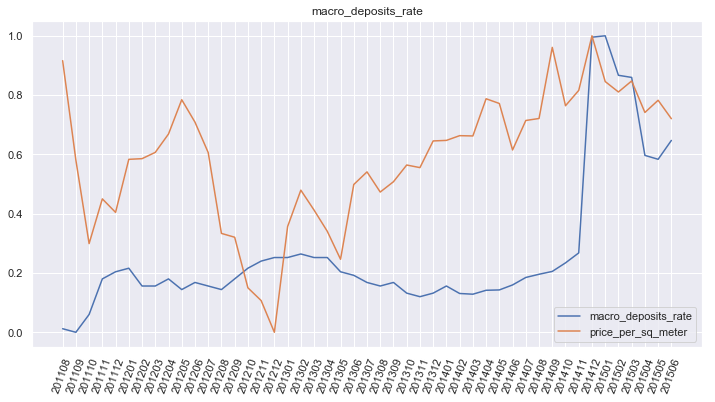

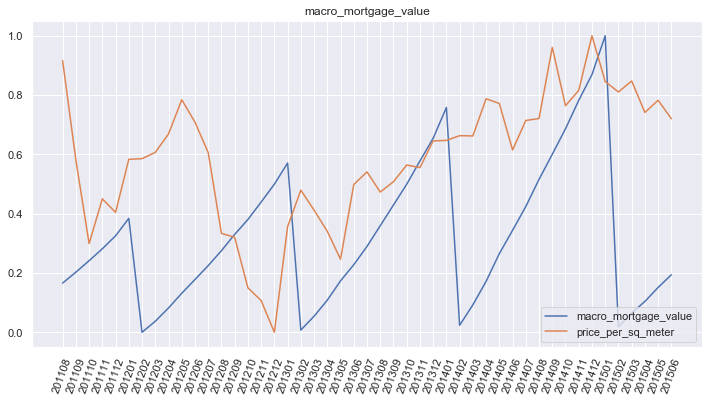

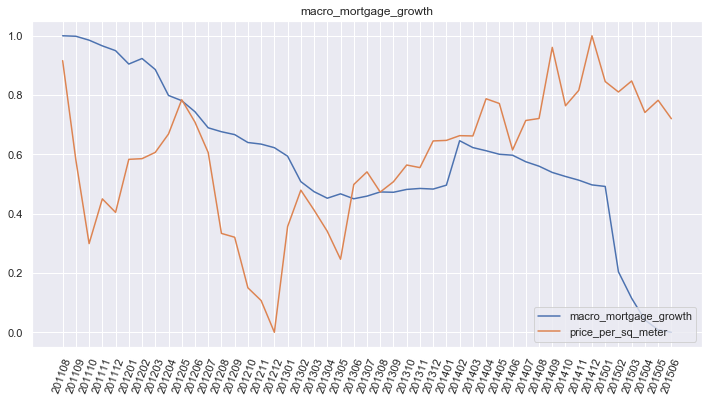

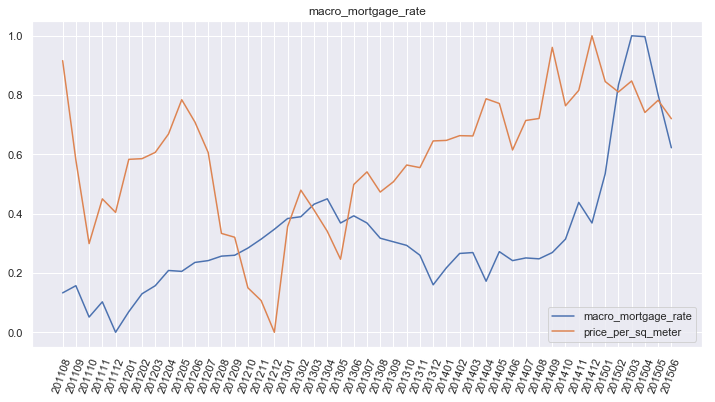

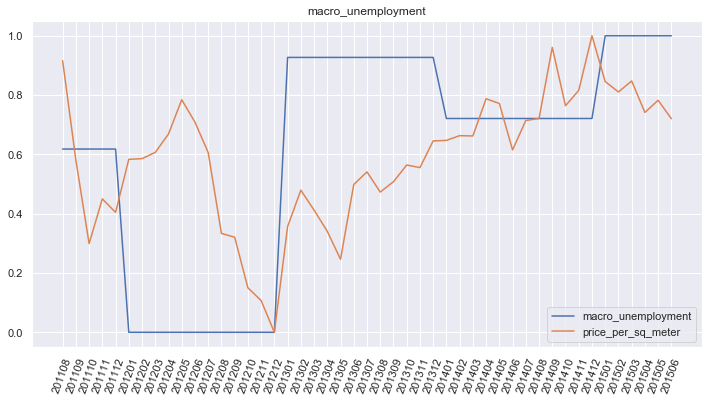

In [12]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

macro_df_for_scaling = macro_with_avg_price_df_grouped.replace([np.inf, -np.inf], np.nan)

# macro_df_for_scaling = macro_df_for_scaling.fillna(method="ffill")
macro_df_for_scaling = macro_with_avg_price_df_grouped.replace([np.inf, -np.inf], np.nan)
macro_df_for_scaling = macro_df_for_scaling.interpolate()

macro_df_scaled = pd.DataFrame(scaler.fit_transform(macro_df_for_scaling),
                               columns=macro_df_for_scaling.columns,
                               index=macro_df_for_scaling.index)
# macro_col = "macro_gdp_quart"

for macro_col in mcols[2:]:

    plt.figure(figsize=(12,6))

    plt.plot(macro_df_scaled.index, macro_df_scaled[macro_col], label=macro_col)
    plt.plot(macro_df_scaled.index, macro_df_scaled['price_per_sq_meter'], label='price_per_sq_meter')

    plt.title(macro_col)
    plt.legend(loc='lower right')
    plt.xticks(rotation=70)

    plt.show()

In [68]:
macro_with_avg_price_df_corr = macro_with_avg_price_df.corr()
macro_with_avg_price_df_corr = macro_with_avg_price_df_corr.where(
    ~np.triu(np.ones(macro_with_avg_price_df_corr.shape)).astype(np.bool)).stack().reset_index()
macro_with_avg_price_df_corr.columns = ["feature1", "feature2", "corr_value"]
# macro_with_avg_price_df_corr.corr_value = macro_with_avg_price_df_corr.corr_value.round(9)

In [69]:
macro_with_avg_price_df_corr.where(
    macro_with_avg_price_df_corr.feature2=="avg_month_price_per_sqm").dropna().corr_value.round(8)

Series([], Name: corr_value, dtype: float64)

In [ ]:
train_gb = train_df.groupby(['timestamp_year_month'])

dfagg = pd.DataFrame()
dfagg['avg_price_per_sqm'] = train_gb.price_doc.sum() / train_gb.full_sq.sum()
dfagg['rolling_average_immo'] = dfagg['avg_price_per_sqm'].rolling(30).mean()
dfagg.reset_index(inplace=True)

In [217]:
# gdp_annual
# gdp_annual_growth
# gdp_deflator
# gdp_quart
# gdp_quart_growth

# grp
# grp_growth

# cpi
# ppi

# oil_urals
# usdrub
# eurrub

# micex
# micex_cbi_tr
# micex_rgbi_tr

# rent_price_1room_bus
# rent_price_1room_eco
# rent_price_2room_bus
# rent_price_2room_eco
# rent_price_3room_bus
# rent_price_3room_eco
# rent_price_4+room_bus

# apartment_build
# apartment_fund_sqm
# average_life_exp
# average_provision_of_build_contract
# average_provision_of_build_contract_moscow
# balance_trade
# balance_trade_growth
# bandwidth_sports
# baths_share
# brent
# child_on_acc_pre_school
# childbirth
# construction_value
# date
# deposits_growth
# deposits_rate
# deposits_value
# divorce_rate
# electric_stove_share
# employment
# fin_res_per_cap
# fixed_basket
# gas_share
# heating_share
# hospital_bed_occupancy_per_year
# hospital_beds_available_per_cap
# hot_water_share
# housing_fund_sqm
# incidence_population
# income_per_cap
# infant_mortarity_per_1000_cap
# invest_fixed_assets
# invest_fixed_assets_phys
# invest_fixed_capital_per_cap
# labor_force
# load_of_teachers_preschool_per_teacher
# load_of_teachers_school_per_teacher
# load_on_doctors
# lodging_sqm_per_cap
# marriages_per_1000_cap
# modern_education_share
# mortality
# mortgage_growth
# mortgage_rate
# mortgage_value
# museum_visitis_per_100_cap
# net_capital_export
# old_education_build_share
# old_house_share
# overdue_wages_per_cap
# perinatal_mort_per_1000_cap
# pop_migration
# pop_natural_increase
# pop_total_inc
# population_reg_sports_share
# power_clinics
# profitable_enterpr_share
# provision_doctors
# provision_nurse
# provision_retail_space_modern_sqm
# provision_retail_space_sqm
# real_dispos_income_per_cap_growth

# retail_trade_turnover
# retail_trade_turnover_growth
# retail_trade_turnover_per_cap
# rts
# salary
# salary_growth
# seats_theather_rfmin_per_100000_cap
# sewerage_share
# share_own_revenues
# students_reg_sports_share
# students_state_oneshift
# theaters_viewers_per_1000_cap
# timestamp
# turnover_catering_per_cap
# unemployment
# unprofitable_enterpr_share
# water_pipes_share

In [23]:
# first let's average per day
gb_train = train_df.groupby(['timestamp'])
dfagg = pd.DataFrame()
dfagg['avg_price_per_sqm'] = gb_train.price_doc.sum() / gb_train.full_sq.sum()
dfagg['rolling_average_immo'] = dfagg['avg_price_per_sqm'].rolling(30).mean()
dfagg.reset_index(inplace=True)
dfagg = pd.merge(dfagg, macro_df, how='left', on=['timestamp'])

In [35]:
macro_df.columns

Index(['timestamp', 'oil_urals', 'gdp_quart', 'gdp_quart_growth', 'cpi', 'ppi',
       'gdp_deflator', 'balance_trade', 'balance_trade_growth', 'usdrub',
       ...
       'turnover_catering_per_cap', 'theaters_viewers_per_1000_cap',
       'seats_theather_rfmin_per_100000_cap', 'museum_visitis_per_100_cap',
       'bandwidth_sports', 'population_reg_sports_share',
       'students_reg_sports_share', 'apartment_build', 'apartment_fund_sqm',
       'date'],
      dtype='object', length=101)